<a href="https://colab.research.google.com/github/chenant2017/breast-cancer/blob/main/Early_Detection_of_Breast_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, validation_curve, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, confusion_matrix, accuracy_score, classification_report, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


- Feature selection
  - 10 trials with different random states, giving 10 lists of features to keep
  - Tally up how many times each feature shows up
  - Rank the features by tally
  - Take first n features from the ranking, where n is the average length of the 10 lists.
- Best hyperparams for CV and test data are different!
  - First do similar procedure as Street et. al, show you can beat them
  - Then present your own thing.

In [ ]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", header = None)

In [ ]:
col_names = ["{}{}".format(s, i) for i in range(1, 4) for s in ["Radius", "Texture", "Perimeter", "Area", "Smoothness", "Compactness", "Concavity", "ConcavePoints", "Symmetry", "FractalDimension"]]
df.columns = ["ID number", "Diagnosis"] + col_names
df = df.drop(labels="ID number", axis=1)

# EDA, Plotting

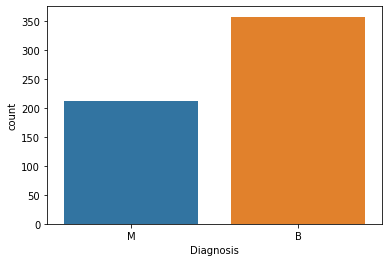

In [ ]:
sns.countplot(x="Diagnosis", data=df)

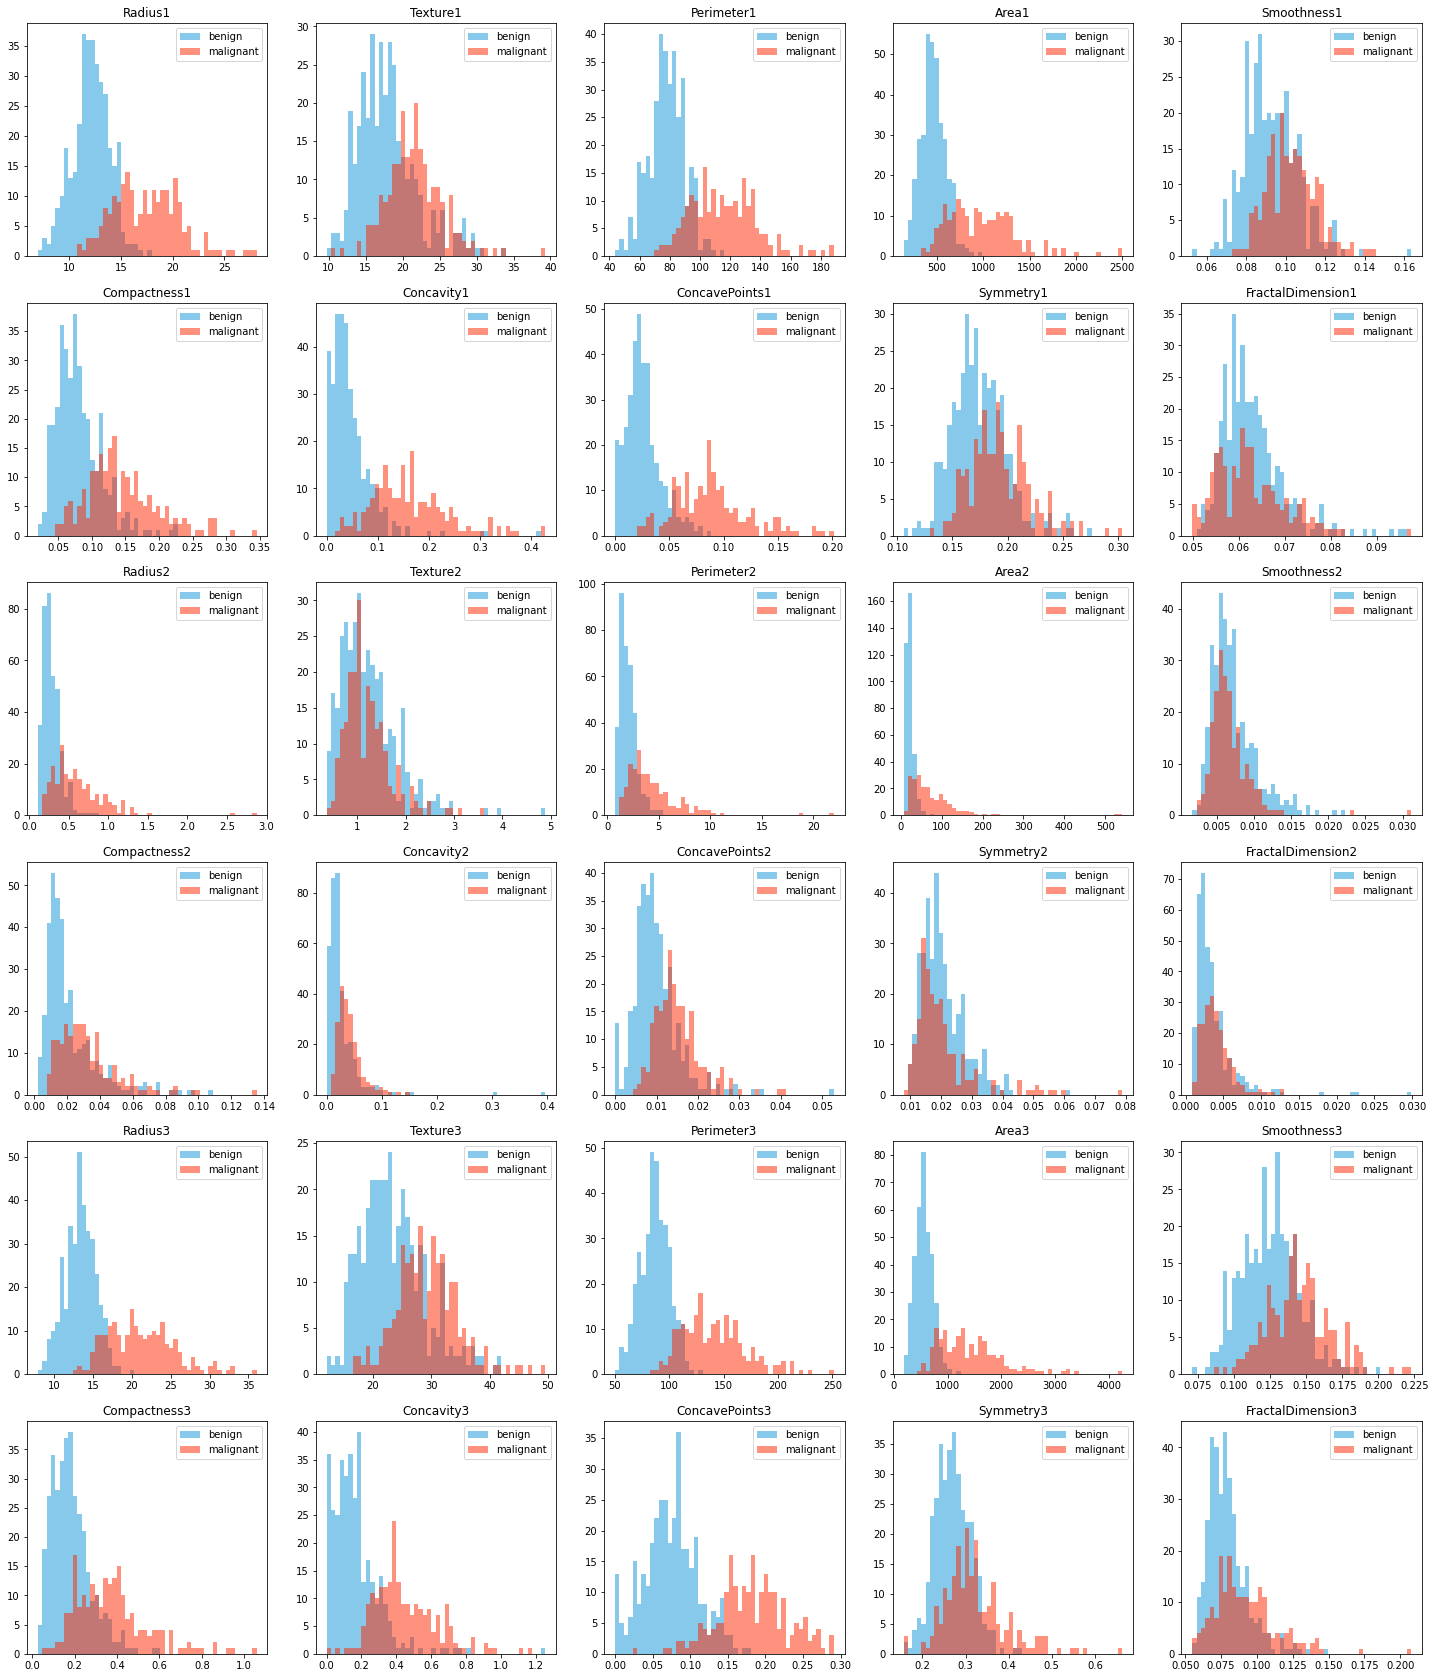

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(25, 30))
for i, col in enumerate(col_names):
    subplot = axes[i//5, i%5]
    subplot.hist((df.loc[df.Diagnosis=='M', col], df.loc[df.Diagnosis=='B', col]),
                   bins=50, alpha=0.5, label=['malignant', 'benign'], color=['#FF2700', '#0F95D7'], histtype='stepfilled')
    subplot.legend(loc='upper right')
    subplot.title.set_text(f"{col}")

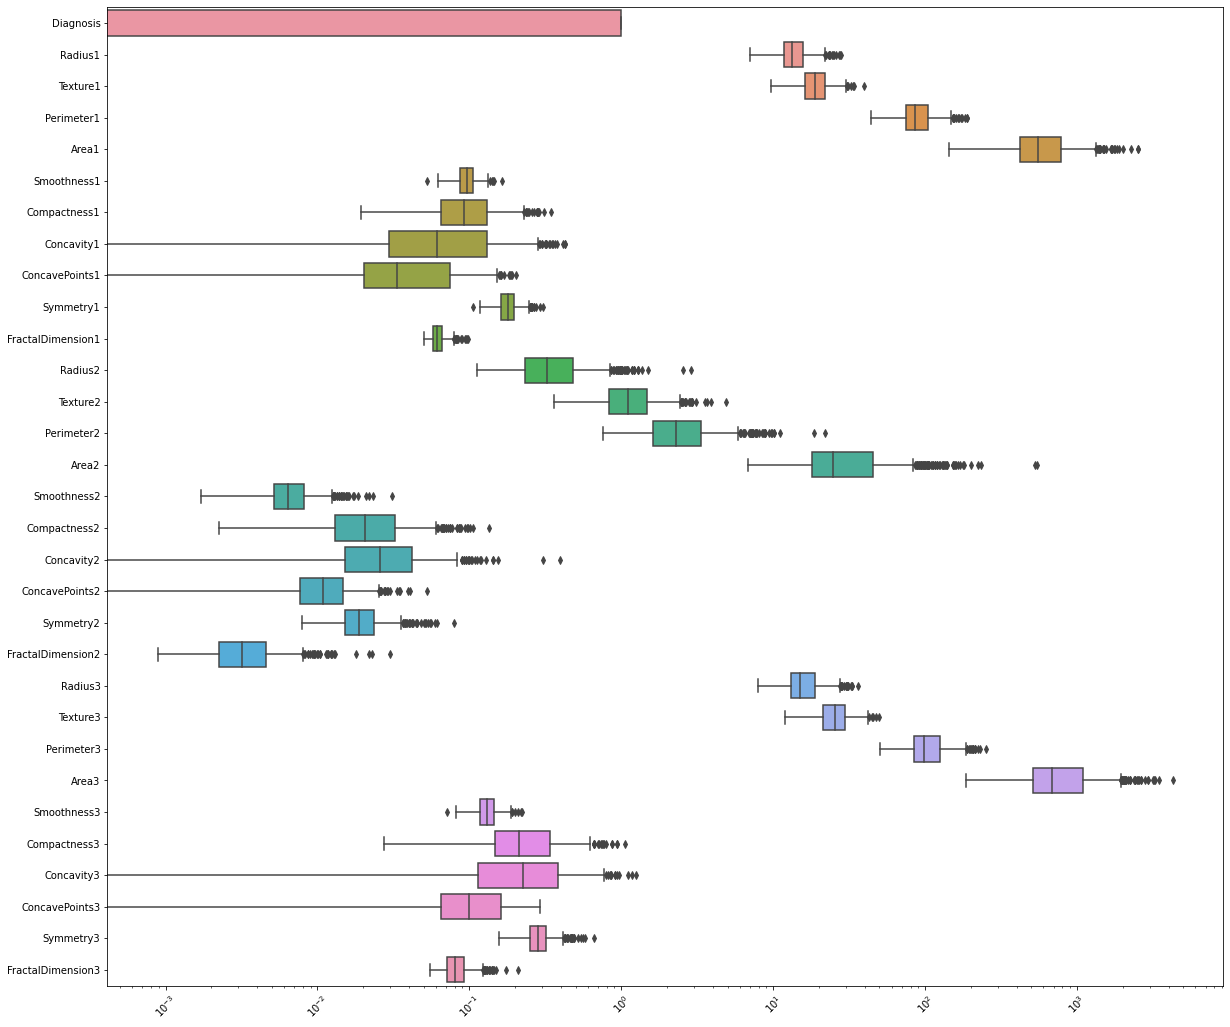

In [ ]:
fig, ax = plt.subplots(figsize=(20, 18))
sns.boxplot(data=df, ax=ax, orient="h")
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set(xscale="log")
plt.show()


In [ ]:
import math
for i in col_names:
  if i[-1] == "2":
    q = df.query("{} > 0".format(i))
    print("AAAA", i, len(q))
    for j in range(len(df[i])):
      if df[i][j] > 0:
        df[i][j] = math.log(df[i][j])
      else:
        df[i][j] = math.log(min(q[i]))

AAAA Radius2 569


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


AAAA Texture2 569
AAAA Perimeter2 569
AAAA Area2 569
AAAA Smoothness2 569
AAAA Compactness2 569
AAAA Concavity2 556


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


AAAA ConcavePoints2 556
AAAA Symmetry2 569
AAAA FractalDimension2 569


In [ ]:
df_corr = df.drop("Diagnosis", axis=1).corr()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(data=df_corr, cmap = sns.cm.rocket_r, ax=ax, mask = np.triu(np.ones_like(df.corr(), dtype=bool)), annot=True, fmt='.2f')

Error in callback <function flush_figures at 0x7f92c47f40e0> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
le = LabelEncoder()
df["Diagnosis"] = le.fit_transform(df["Diagnosis"])

# Feature Selection


In [ ]:
correlated_features = set()
for i in range(len(df_corr.columns)):
    for j in range(i):
        if abs(df_corr.iloc[i, j]) > 0.9:
            colname = df_corr.columns[i]
            correlated_features.add(colname)

In [ ]:
X = df.drop(correlated_features, axis=1)
X.drop(columns="Diagnosis", inplace=True)
y = df["Diagnosis"]

In [ ]:
for i in [100, 101, 102, 103, 104, 105, 106, 107, 108, 109]:
  print(i)
  rfc = RandomForestClassifier(random_state=i)
  rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
  rfecv.fit(X, y)
  print(X.columns[np.where(rfecv.support_==True)])
  print(rfecv.n_features_)

100


KeyboardInterrupt: ignored

In [ ]:
np.median([16, 20, 18, 18, 19, 14, 15, 15, 14, 16])

16.0

In [ ]:
selected = [['Radius1', 'Texture1', 'Smoothness1', 'Compactness1', 'Concavity1',
       'FractalDimension1', 'Radius2', 'Compactness2', 'Concavity2',
       'ConcavePoints2', 'FractalDimension2', 'Smoothness3', 'Compactness3',
       'Concavity3', 'Symmetry3', 'FractalDimension3'],
['Radius1', 'Texture1', 'Smoothness1', 'Compactness1', 'Concavity1',
       'Symmetry1', 'FractalDimension1', 'Radius2', 'Texture2', 'Smoothness2',
       'Compactness2', 'Concavity2', 'ConcavePoints2', 'Symmetry2',
       'FractalDimension2', 'Smoothness3', 'Compactness3', 'Concavity3',
       'Symmetry3', 'FractalDimension3'],
['Radius1', 'Texture1', 'Smoothness1', 'Compactness1', 'Concavity1',
       'FractalDimension1', 'Radius2', 'Smoothness2', 'Compactness2',
       'Concavity2', 'ConcavePoints2', 'Symmetry2', 'FractalDimension2',
       'Smoothness3', 'Compactness3', 'Concavity3', 'Symmetry3',
       'FractalDimension3'],
['Radius1', 'Texture1', 'Smoothness1', 'Compactness1', 'Concavity1',
       'FractalDimension1', 'Radius2', 'Smoothness2', 'Compactness2',
       'Concavity2', 'ConcavePoints2', 'Symmetry2', 'FractalDimension2',
       'Smoothness3', 'Compactness3', 'Concavity3', 'Symmetry3',
       'FractalDimension3'],
['Radius1', 'Texture1', 'Smoothness1', 'Compactness1', 'Concavity1',
       'FractalDimension1', 'Radius2', 'Texture2', 'Smoothness2',
       'Compactness2', 'Concavity2', 'ConcavePoints2', 'Symmetry2',
       'FractalDimension2', 'Smoothness3', 'Compactness3', 'Concavity3',
       'Symmetry3', 'FractalDimension3'],
['Radius1', 'Texture1', 'Compactness1', 'Concavity1',
       'FractalDimension1', 'Radius2', 'Compactness2', 'Concavity2',
       'FractalDimension2', 'Smoothness3', 'Compactness3', 'Concavity3',
       'Symmetry3', 'FractalDimension3'],
['Radius1', 'Texture1', 'Smoothness1', 'Compactness1', 'Concavity1',
       'FractalDimension1', 'Radius2', 'Compactness2', 'Concavity2',
       'Symmetry2', 'FractalDimension2', 'Smoothness3', 'Compactness3',
       'Concavity3', 'Symmetry3'],
['Radius1', 'Texture1', 'Smoothness1', 'Compactness1', 'Concavity1',
       'FractalDimension1', 'Radius2', 'Compactness2', 'Concavity2',
       'Symmetry2', 'FractalDimension2', 'Smoothness3', 'Compactness3',
       'Concavity3', 'Symmetry3'],
['Radius1', 'Texture1', 'Smoothness1', 'Compactness1', 'Concavity1',
       'FractalDimension1', 'Radius2', 'Compactness2', 'Concavity2',
       'ConcavePoints2', 'Smoothness3', 'Compactness3', 'Concavity3',
       'Symmetry3'],
['Radius1', 'Texture1', 'Smoothness1', 'Compactness1', 'Concavity1',
       'FractalDimension1', 'Radius2', 'Compactness2', 'Concavity2',
       'ConcavePoints2', 'Symmetry2', 'FractalDimension2', 'Smoothness3',
       'Compactness3', 'Concavity3', 'Symmetry3']]

In [ ]:
counts = {}
for i in selected:
  for j in i:
    if j in counts.keys():
      counts[j] += 1
    else:
      counts[j] = 1
counts

{'Compactness1': 10,
 'Compactness2': 10,
 'Compactness3': 10,
 'ConcavePoints2': 7,
 'Concavity1': 10,
 'Concavity2': 10,
 'Concavity3': 10,
 'FractalDimension1': 10,
 'FractalDimension2': 9,
 'FractalDimension3': 6,
 'Radius1': 10,
 'Radius2': 10,
 'Smoothness1': 9,
 'Smoothness2': 4,
 'Smoothness3': 10,
 'Symmetry1': 1,
 'Symmetry2': 7,
 'Symmetry3': 10,
 'Texture1': 10,
 'Texture2': 2}

In [ ]:
selected_features = ["Compactness1", "Compactness2", "Compactness3",
 "Concavity1","Concavity2", "Concavity3",
 "FractalDimension1", "FractalDimension2",
 "Radius1", "Radius2",
 "Smoothness1", "Smoothness3",
 "Symmetry2", "Symmetry3", "Texture1",
 "ConcavePoints2"]

In [ ]:
X = X[selected_features]
X

,Compactness1,Compactness2,Compactness3,Concavity1,Concavity2,Concavity3,FractalDimension1,FractalDimension2,Radius1,Radius2,Smoothness1,Smoothness3,Symmetry2,Symmetry3,Texture1,ConcavePoints2
0,0.27760,-3.015119,0.66560,0.30010,-2.923784,0.7119,0.07871,-5.084336,17.99,0.090754,0.11840,0.16220,-3.505558,0.4601,10.38,-4.143325
1,0.07864,-4.336671,0.18660,0.08690,-3.984594,0.2416,0.05667,-5.645891,20.57,-0.609726,0.08474,0.12380,-4.276586,0.2750,17.77,-4.312501
2,0.15990,-3.217377,0.42450,0.19740,-3.261783,0.4504,0.05999,-5.388023,19.69,-0.293566,0.10960,0.14440,-3.794240,0.3613,21.25,-3.883436
3,0.28390,-2.595883,0.86630,0.24140,-2.871570,0.6869,0.09744,-4.687683,11.42,-0.701986,0.14250,0.20980,-2.819596,0.6638,20.38,-3.980837
4,0.13280,-3.704602,0.20500,0.19800,-2.866811,0.4000,0.05883,-5.275578,20.29,-0.278128,0.10030,0.13740,-4.042132,0.2364,14.34,-3.971242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.11590,-3.543568,0.21130,0.24390,-2.956896,0.4107,0.05623,-5.463428,21.56,0.162119,0.11100,0.14100,-4.497213,0.2060,22.39,-3.707451
565,0.10340,-3.720164,0.19220,0.14400,-3.231455,0.3215,0.05533,-5.992265,20.13,-0.267226,0.09780,0.11660,-3.964369,0.2572,28.25,-4.087568
566,0.10230,-3.288494,0.30940,0.09251,-3.051245,0.3403,0.05648,-5.548832,16.60,-0.784386,0.08455,0.11390,-4.329055,0.2218,28.08,-4.162409
567,0.27700,-2.787418,0.86810,0.35140,-2.642684,0.9387,0.07016,-5.085628,20.60,-0.320205,0.11780,0.16500,-3.761880,0.4087,29.33,-4.095946


#Data split and cv

In [ ]:
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)

# Function

In [ ]:
def function(model, params, stratified_kfold, trainX, trainY, testX, testY):
  pipeline = Pipeline([['smote', SMOTE(random_state=42)],
                    ['scaler', MinMaxScaler()],
                    ['classifier', model]])
  grid_search = GridSearchCV(estimator=pipeline,
                             param_grid=params,
                             scoring="accuracy",
                             cv=stratified_kfold,
                             n_jobs=-1)
  grid_search.fit(trainX, trainY)
  print(grid_search.best_params_, "|", grid_search.best_score_)
  estimator = grid_search.best_estimator_
  estimator.fit(trainX, trainY)
  predicted = estimator.predict(testX)
  accuracy = accuracy_score(testY, predicted)
  print(accuracy)
  return accuracy



In [ ]:
def function2(X, y, model, params, stratified_kfold):
  cv_split = stratified_kfold.split(X, y)
  sum = 0
  for i in cv_split:
    train, test = i
    trainX = X.iloc[train]
    trainY = y.iloc[train]
    testX = X.iloc[test]
    testY = y.iloc[test]
    sum += function(model, params, stratified_kfold, trainX, trainY, testX, testY)
    print("Done")
  final = sum/10
  print("FINAL ACCURACY", final)
  return final

# Logistic Regression

##My procedure

In [ ]:
pipeline = Pipeline([['smote', SMOTE(random_state=42)],
                    ['scaler', MinMaxScaler()],
                    ['classifier', LogisticRegression(random_state=101, max_iter=1000, n_jobs = -1)]])

In [ ]:
params = {'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'classifier__penalty': ['none', 'l1', 'l2', 'elasticnet'], 'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline, param_grid=params, scoring="roc_auc", cv=stratified_kfold, n_jobs=-1) #accuracy?
grid_search.fit(trainX, trainY)
print(grid_search.best_params_, "|", grid_search.best_score_)

{'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'} | 0.9941538684439294


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
630 fits failed out of a total of 1400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)


In [ ]:
grid_search.best_params_

{'classifier__C': 10,
 'classifier__penalty': 'l2',
 'classifier__solver': 'newton-cg'}

In [ ]:
{'classifier__C': 10,
 'classifier__penalty': 'l2',
 'classifier__solver': 'newton-cg'}

In [ ]:
estimator = grid_search.best_estimator_
estimator.fit(trainX, trainY)

Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scaler', MinMaxScaler()),
                ['classifier',
                 LogisticRegression(C=10, max_iter=1000, n_jobs=-1,
                                    random_state=101, solver='newton-cg')]])

In [ ]:
predicted = estimator.predict(testX)
print(accuracy_score(testY, predicted))

0.9824561403508771


In [ ]:
Accuracy: 0.9824561403508771

## My Procedure II

In [ ]:
result1 = function2(X, y, LogisticRegression(random_state=101, max_iter=1000, n_jobs = -1),
          {'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
           'classifier__penalty': ['none', 'l1', 'l2', 'elasticnet'],
           'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]},
          stratified_kfold)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
630 fits failed out of a total of 1400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)


{'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'} | 0.9745852187028656
0.9824561403508771
Done


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
630 fits failed out of a total of 1400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)


{'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'} | 0.9706259426847662
1.0
Done


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
630 fits failed out of a total of 1400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)


{'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'} | 0.9803921568627452
0.9473684210526315
Done


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
630 fits failed out of a total of 1400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)


{'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'} | 0.9765837104072398
0.9473684210526315
Done


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
630 fits failed out of a total of 1400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)


{'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'} | 0.9687405731523379
0.9824561403508771
Done


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
630 fits failed out of a total of 1400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)


{'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'} | 0.9784690799396681
0.9649122807017544
Done


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
630 fits failed out of a total of 1400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)


{'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'} | 0.9707390648567118
1.0
Done


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
630 fits failed out of a total of 1400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)


{'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'} | 0.9725867269984917
0.9298245614035088
Done


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
630 fits failed out of a total of 1400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)


{'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'} | 0.974660633484163
0.9649122807017544
Done


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
630 fits failed out of a total of 1400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)


{'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'} | 0.972737556561086
0.9821428571428571
Done
FINAL ACCURACY 0.9701441102756891


In [ ]:
result1 = 0.9701441102756891

NameError: ignored

##Street's Procedure

In [ ]:
estimator.fit(X, y)
score = cross_val_score(estimator=estimator, X=X, y=y, scoring="accuracy", cv=stratified_kfold2)

In [ ]:
np.average(score)

0.9754072681704262

In [ ]:
0.9754072681704262

# Random Forest

**# Update: tuning using validation curves improved accuracy to ~97.4%**


##My procedure

In [ ]:
pipeline2 = Pipeline([['smote', SMOTE(random_state=42)],
                      ['scaler', MinMaxScaler()],
                      ['classifier', RandomForestClassifier(n_estimators=100, random_state=101)]])

In [ ]:
params = {#'classifier__bootstrap': [True, False], #True
          'classifier__max_depth': [6, 7, 8, 9, 10, None], #8
          'classifier__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, "auto"], #5
          #'classifier__min_samples_leaf': [1, 2, 3, 4, 5], #1
          #'classifier__min_samples_split': [2, 3, 4, 5, 6], #2
          'classifier__n_estimators': [100, 150, 200, 250, 300] #100
}

grid_search = GridSearchCV(estimator=pipeline2, param_grid=params, scoring="roc_auc", cv=stratified_kfold, n_jobs=-1) #accuracy?
grid_search.fit(trainX, trainY)
print(grid_search.best_params_, "|", grid_search.best_score_)

In [ ]:
params = {
          'classifier__max_depth': [None], #8
          'classifier__max_features': ["auto"], #5
          #'classifier__min_samples_leaf': [1, 2, 3, 4, 5], #1
          #'classifier__min_samples_split': [2, 3, 4, 5, 6], #2
          'classifier__n_estimators': [100] #100
}

grid_search = GridSearchCV(estimator=pipeline2, param_grid=params, scoring="accuracy", cv=stratified_kfold, n_jobs=-1) #accuracy?
grid_search.fit(trainX, trainY)
print(grid_search.best_params_, "|", grid_search.best_score_)

{'classifier__max_depth': None, 'classifier__max_features': 'auto', 'classifier__n_estimators': 100} | 0.9647342995169081


In [ ]:
{'classifier__max_depth': 7, 'classifier__max_features': 5, 'classifier__n_estimators': 150} | 0.971304347826087

In [ ]:
estimator2 = grid_search.best_estimator_

In [ ]:
estimator2.fit(trainX, trainY)
predicted2 = estimator2.predict(testX)
print(accuracy_score(testY, predicted2))

0.9649122807017544


In [ ]:
estimator2 = Pipeline([['smote', SMOTE(random_state=42)],
                       ['scaler', MinMaxScaler()],
                       ['classifier', RandomForestClassifier(#bootstrap=True,
                                                             max_depth=7,
                                                             max_features=5,
                                                             #min_samples_leaf=1,
                                                             #min_samples_split=2,
                                                             n_estimators=150,
                                                             random_state=101)]])

In [ ]:
estimator2 = Pipeline([['smote', SMOTE(random_state=42)],
                       ['scaler', MinMaxScaler()],
                       ['classifier', RandomForestClassifier(random_state=101)]])

In [ ]:
0.9649122807017544

In [ ]:
estimator2

Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scaler', MinMaxScaler()),
                ['classifier',
                 RandomForestClassifier(max_depth=7, max_features=5,
                                        n_estimators=150, random_state=101)]])

##Street's Procedure

In [ ]:
estimator2.fit(X, y)
score2 = cross_val_score(estimator=estimator2, X=X, y=y, scoring="accuracy", cv=stratified_kfold2)

In [ ]:
np.average(score2)

0.9543546365914788

In [ ]:
score2

array([0.96491228, 1.        , 0.98245614, 0.89473684, 0.94736842,
       0.94736842, 0.94736842, 0.9122807 , 0.96491228, 0.98214286])

In [ ]:
estimator2

Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scaler', MinMaxScaler()),
                ['classifier',
                 RandomForestClassifier(max_depth=7, max_features=5,
                                        n_estimators=150, random_state=101)]])

In [ ]:
0.9543546365914788

# My Procedure II

In [ ]:
result2 = function2(X, y, RandomForestClassifier(random_state=101),
          {'classifier__max_depth': [6, 8, 10, None],
          'classifier__max_features': [1, 5, 10, "auto"],
          'classifier__n_estimators': [100, 150, 200]},
          stratified_kfold)


{'classifier__max_depth': 6, 'classifier__max_features': 5, 'classifier__n_estimators': 100} | 0.9647812971342382
0.9824561403508771
Done
{'classifier__max_depth': 10, 'classifier__max_features': 10, 'classifier__n_estimators': 100} | 0.9667420814479637
0.9824561403508771
Done
{'classifier__max_depth': 10, 'classifier__max_features': 'auto', 'classifier__n_estimators': 100} | 0.9647435897435898
1.0
Done
{'classifier__max_depth': 10, 'classifier__max_features': 5, 'classifier__n_estimators': 200} | 0.9668552036199095
0.9298245614035088
Done
{'classifier__max_depth': 8, 'classifier__max_features': 'auto', 'classifier__n_estimators': 100} | 0.9610105580693815
0.9473684210526315
Done
{'classifier__max_depth': 8, 'classifier__max_features': 10, 'classifier__n_estimators': 100} | 0.9627450980392156
0.9473684210526315
Done
{'classifier__max_depth': 10, 'classifier__max_features': 5, 'classifier__n_estimators': 200} | 0.9590120663650075
0.9473684210526315
Done
{'classifier__max_depth': 8, 'cla

In [ ]:
result2

0.9596491228070176

# K-Nearest Neighbors

##My procedure

In [ ]:
pipeline3 = Pipeline([['smote', SMOTE(random_state=42)],
                    ['scaler', MinMaxScaler()],
                    ['classifier', KNeighborsClassifier(n_jobs = -1)]])

In [ ]:
leaf_size=list(range(1,51))
n_neighbors = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19] #check why this is worse than default
#metric = ["euclidean", "manhattan", "minkowski"]
p=[1, 2]
weights = ['uniform', 'distance']

params = {'classifier__leaf_size': leaf_size,
          'classifier__n_neighbors': n_neighbors,
          'classifier__p': p,
          'classifier__weights': weights}

grid_search = GridSearchCV(estimator=pipeline3, param_grid=params, cv=stratified_kfold, scoring="roc_auc", n_jobs = -1)

grid_search.fit(trainX, trainY)
print(grid_search.best_params_, "|", grid_search.best_score_)

KeyboardInterrupt: ignored

In [ ]:
{'classifier__leaf_size': 1, 'classifier__n_neighbors': 17, 'classifier__p': 2, 'classifier__weights': 'distance'} | 0.990596928426543

In [ ]:
estimator3 = Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scaler', MinMaxScaler()),
                ['classifier',
                 KNeighborsClassifier(
                                      leaf_size=1,
                                      n_jobs=-1,
                                      n_neighbors=17,
                                      p=2,
                                      weights='distance')]])

In [ ]:
#estimator3 = grid_search.best_estimator_
estimator3.fit(trainX, trainY)

Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scaler', MinMaxScaler()),
                ['classifier',
                 KNeighborsClassifier(leaf_size=1, n_jobs=-1, n_neighbors=17,
                                      weights='distance')]])

In [ ]:
predicted3 = estimator3.predict(testX)
print(accuracy_score(testY, predicted3))

0.956140350877193


In [ ]:
0.956140350877193

0.956140350877193

##Street's Procedure

In [ ]:
estimator3.fit(X, y)
score3 = cross_val_score(estimator=estimator3, X=X, y=y, scoring="accuracy", cv=stratified_kfold2)

In [ ]:
score3

array([0.98245614, 0.98245614, 0.96491228, 0.9122807 , 0.94736842,
       0.94736842, 0.96491228, 0.85964912, 0.92982456, 0.94642857])

In [ ]:
np.average(score3)

0.943765664160401

In [ ]:
0.943765664160401

0.943765664160401

# My Procedure II

In [ ]:
leaf_size=list(range(20, 51, 10))
n_neighbors = [3, 5, 7, 9, 11, 13, 15]
p=[1, 2]
weights = ['uniform', 'distance']

params = {'classifier__leaf_size': leaf_size,
          'classifier__n_neighbors': n_neighbors,
          'classifier__p': p,
          'classifier__weights': weights}

result3 = function2(X, y, KNeighborsClassifier(n_jobs = -1),
          params,
          stratified_kfold)


{'classifier__leaf_size': 20, 'classifier__n_neighbors': 7, 'classifier__p': 2, 'classifier__weights': 'uniform'} | 0.9550150829562594
0.9649122807017544
Done
{'classifier__leaf_size': 20, 'classifier__n_neighbors': 5, 'classifier__p': 1, 'classifier__weights': 'uniform'} | 0.956975867269985
1.0
Done
{'classifier__leaf_size': 20, 'classifier__n_neighbors': 3, 'classifier__p': 2, 'classifier__weights': 'uniform'} | 0.9608220211161388
0.9649122807017544
Done
{'classifier__leaf_size': 20, 'classifier__n_neighbors': 3, 'classifier__p': 1, 'classifier__weights': 'uniform'} | 0.966892911010558
0.9122807017543859
Done
{'classifier__leaf_size': 20, 'classifier__n_neighbors': 3, 'classifier__p': 2, 'classifier__weights': 'uniform'} | 0.9570135746606334
0.9298245614035088
Done
{'classifier__leaf_size': 20, 'classifier__n_neighbors': 5, 'classifier__p': 2, 'classifier__weights': 'uniform'} | 0.9648567119155353
0.9122807017543859
Done
{'classifier__leaf_size': 20, 'classifier__n_neighbors': 3, 'cl

In [ ]:
result3

0.9455513784461151

# SVM

##My procedure

In [ ]:
pipeline4 = Pipeline([['smote', SMOTE(random_state=42)],
                    ['scaler', MinMaxScaler()],
                    ['classifier', SVC(probability=True, random_state=101)]])

In [ ]:
params = {
          'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
          'classifier__gamma': ['scale', 'auto'],
          'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline4, param_grid=params, cv=stratified_kfold, scoring="roc_auc", n_jobs = -1)

grid_search.fit(trainX, trainY)
print(grid_search.best_params_, "|", grid_search.best_score_)

{'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'} | 0.9945812807881772


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 217, in fit
    " Input is a {}x{} matrix.".format(X.shape[0], X.shape[1])
ValueError: Preco

In [ ]:
grid_search.best_params_

{'classifier__C': 0.1,
 'classifier__gamma': 'scale',
 'classifier__kernel': 'poly'}

In [ ]:
{'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}

In [ ]:
estimator4 = grid_search.best_estimator_

In [ ]:
estimator4=Pipeline([['smote', SMOTE(random_state=42)],
                    ['scaler', MinMaxScaler()],
                    ['classifier', SVC(probability=True, C=1, gamma="scale", kernel="rbf",random_state=101)]])

In [ ]:
estimator4.fit(trainX, trainY)
predicted4 = estimator4.predict(testX)
print(accuracy_score(testY, predicted4))

0.9736842105263158


In [ ]:
estimator4.predict_proba(testX)

In [ ]:
#0.9824561403508771
0.9736842105263158

##Street's Procedure

In [ ]:
estimator4.fit(X, y)
score4 = cross_val_score(estimator=estimator4, X=X, y=y, scoring="accuracy", cv=stratified_kfold2)

In [ ]:
np.average(score4)

0.9771616541353385

In [ ]:
0.9771616541353385

# My Procedure II

In [ ]:

result4 = function2(X, y, SVC(probability=True, random_state=101),
          {'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
          'classifier__gamma': ['scale', 'auto'],
          'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
          stratified_kfold)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
28 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 217, in fit
    " Input is a {}x{} matrix.".format(X.shape[0], X.shape[1])
ValueError: Preco

{'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'} | 0.9784690799396681
1.0
Done


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
28 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 217, in fit
    " Input is a {}x{} matrix.".format(X.shape[0], X.shape[1])
ValueError: Preco

{'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'} | 0.9745098039215687
1.0
Done


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
126 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 217, in fit
    " Input is a {}x{} matrix.".format(X.shape[0], X.shape[1])
ValueError: Prec

{'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'} | 0.9784313725490197
0.9649122807017544
Done


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
126 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 217, in fit
    " Input is a {}x{} matrix.".format(X.shape[0], X.shape[1])
ValueError: Prec

{'classifier__C': 10, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'} | 0.9805052790346908
0.9649122807017544
Done


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
126 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 217, in fit
    " Input is a {}x{} matrix.".format(X.shape[0], X.shape[1])
ValueError: Prec

{'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'} | 0.9804675716440423
0.9473684210526315
Done


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
126 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 217, in fit
    " Input is a {}x{} matrix.".format(X.shape[0], X.shape[1])
ValueError: Prec

{'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'} | 0.9824283559577678
0.9649122807017544
Done


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
126 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 217, in fit
    " Input is a {}x{} matrix.".format(X.shape[0], X.shape[1])
ValueError: Prec

{'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'} | 0.9824660633484162
1.0
Done


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
126 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 217, in fit
    " Input is a {}x{} matrix.".format(X.shape[0], X.shape[1])
ValueError: Prec

{'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'} | 0.9784690799396681
0.9649122807017544
Done


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
126 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 217, in fit
    " Input is a {}x{} matrix.".format(X.shape[0], X.shape[1])
ValueError: Prec

{'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'} | 0.9765082956259427
0.9649122807017544
Done
{'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'} | 0.9806184012066366
0.9821428571428571
Done
FINAL ACCURACY 0.9754072681704262


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
112 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 217, in fit
    " Input is a {}x{} matrix.".format(X.shape[0], X.shape[1])
ValueError: Prec

In [ ]:
result4

0.9754072681704262

#Model Evaluations

In [ ]:
cr_df = pd.DataFrame(classification_report(testY, predicted, output_dict=True)).transpose()
cr_df

,precision,recall,f1-score,support
0,0.972973,1.000000,0.986301,72.000000
1,1.000000,0.952381,0.975610,42.000000
accuracy,0.982456,0.982456,0.982456,0.982456
macro avg,0.986486,0.976190,0.980956,114.000000
weighted avg,0.982930,0.982456,0.982362,114.000000


In [ ]:
cr_df = pd.DataFrame(classification_report(testY, predicted2, output_dict=True)).transpose()
cr_df



,precision,recall,f1-score,support
0,0.972222,0.972222,0.972222,72.000000
1,0.952381,0.952381,0.952381,42.000000
accuracy,0.964912,0.964912,0.964912,0.964912
macro avg,0.962302,0.962302,0.962302,114.000000
weighted avg,0.964912,0.964912,0.964912,114.000000


In [ ]:
cr_df = pd.DataFrame(classification_report(testY, predicted3, output_dict=True)).transpose()
cr_df



,precision,recall,f1-score,support
0,0.958904,0.972222,0.965517,72.00000
1,0.951220,0.928571,0.939759,42.00000
accuracy,0.956140,0.956140,0.956140,0.95614
macro avg,0.955062,0.950397,0.952638,114.00000
weighted avg,0.956073,0.956140,0.956027,114.00000


In [ ]:
cr_df = pd.DataFrame(classification_report(testY, predicted4, output_dict=True)).transpose()
cr_df



,precision,recall,f1-score,support
0,0.972973,1.000000,0.986301,72.000000
1,1.000000,0.952381,0.975610,42.000000
accuracy,0.982456,0.982456,0.982456,0.982456
macro avg,0.986486,0.976190,0.980956,114.000000
weighted avg,0.982930,0.982456,0.982362,114.000000


In [ ]:
testY

120    0
250    1
375    0
99     1
455    0
      ..
381    0
534    0
448    0
205    1
75     1
Name: Diagnosis, Length: 114, dtype: int64

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


auc = 0.9958715446429272


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


auc = 0.9908760110016762


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


auc = 0.9866922588865672
auc = 0.9930168264689987


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


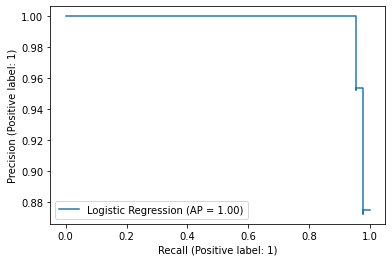

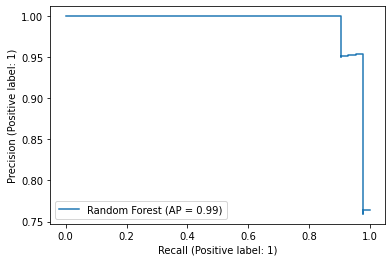

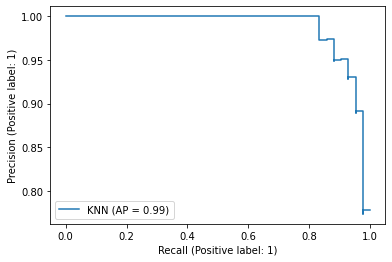

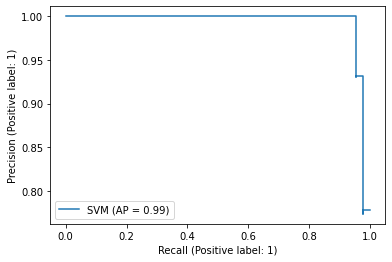

In [ ]:
names=["Logistic Regression", "Random Forest", "KNN", "SVM"]
estimators = [estimator, estimator2, estimator3, estimator4]
for i in range(4): #LR, RF, KNN, SVM
  estimators[i].fit(trainX, trainY)
  probs = estimators[i].predict_proba(testX)
  precision, recall, thresholds = precision_recall_curve(testY, probs[:, 1])
  plot_precision_recall_curve(estimators[i], testX, testY, name=names[i])
  print("auc =", auc(recall, precision))

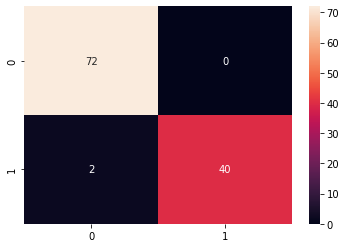

In [ ]:
sns.heatmap(confusion_matrix(testY, predicted), annot=True)


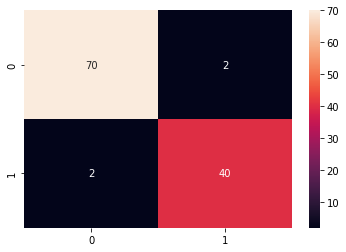

In [ ]:
sns.heatmap(confusion_matrix(testY, predicted2), annot=True)

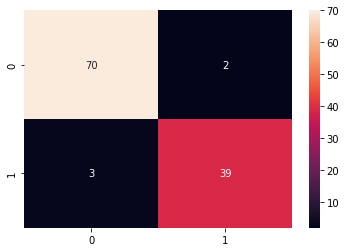

In [ ]:
sns.heatmap(confusion_matrix(testY, predicted3), annot=True)

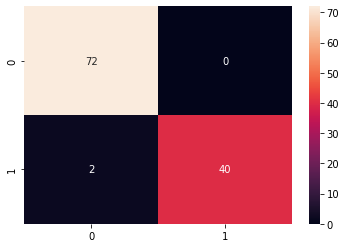

In [ ]:
sns.heatmap(confusion_matrix(testY, predicted4), annot=True)